In [1]:
import gc

import keras.backend as K
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Conv2D, MaxPooling2D, Input, Flatten, Dense
from keras.layers import MaxPooling1D, Conv1D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# USE MIXED PRECISION 
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print("Mixed precision enabled")
else:
    print("Using full precision")

Mixed precision enabled


In [2]:
FS = 400
s, e = 15, 25
a, b = 0, 246
data = np.load("../data/processed/train_img.npy", allow_pickle=True).item()

fmri = data["fMRI"]
rsp = data["RSP"]
ppg = data["PPG"]
bio = np.concatenate((rsp, ppg), axis=-1)

# rsp = data["RSP"][:, 5*FS:]
# ppg = data["PPG"][:, 5*FS:]
# bio = np.stack((rsp[:, ::10], ppg[:, ::10]), axis=-1)
train = np.swapaxes(fmri[:, a:b, s:e], 1, 2)
# train = np.expand_dims(np.swapaxes(fmri[:, :, :], 1, 2),  axis=-1)

subject = data["subject"]
target = data["class"].astype(int) + 1
level = data["level"]

print(f"Data shape: {train.shape}")
print(f"Bio shape: {bio.shape}")
print(f"Subject shape: {subject.shape}")
print(f"Target shape: {target.shape}")
print(f"Level shape: {level.shape}")
print(np.unique(target))

Data shape: (480, 10, 246)
Bio shape: (480, 64, 64, 4)
Subject shape: (480,)
Target shape: (480,)
Level shape: (480,)
[0 1 2]


In [3]:
data_test = np.load("../data/processed/test_img.npy", allow_pickle=True).item()
test_idx = np.where(~np.isnan(data_test["class"]))[0]

y_test = data_test["class"][test_idx].astype(int) + 1
y_test_level = data_test["level"][test_idx]
fmri_test = np.swapaxes(data_test["fMRI"][:, a:b, s:e], 1, 2)
bio_test = np.concatenate((data_test["RSP"][:], data_test["PPG"][:]), axis=-1)

print(f"fMRI shape: {fmri_test.shape}")
print(f"Bio shape: {bio_test.shape}")
print(f"Test target shape: {y_test.shape}")
print("Level shape:", y_test_level.shape)
print(np.unique(y_test))

fMRI shape: (120, 10, 246)
Bio shape: (120, 64, 64, 4)
Test target shape: (36,)
Level shape: (36,)
[0 1 2]


In [4]:
def build_model():
    # Define input shapes
    input_shape_1d = (train.shape[1], train.shape[2])  # Temporal input: 25 time points for 246 brain regions
    input_shape_2d = (train.shape[1], train.shape[2], 1)  # Spatial input: 25x246 spatial grid
    input_shape_bio = (bio.shape[1], bio.shape[2], bio.shape[3])  # PPG and RSP input
    # input_shape_fc = (FCs.shape[1], FCs.shape[1], 1)  # Functional connectivity input
    l2_reg = 1e-2
    dp = 0.25

    # 1D CNN for temporal data
    input_1d = Input(shape=input_shape_1d)
    x1 = Conv1D(filters=32, kernel_size=3, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(input_1d)
    x1 = Conv1D(filters=64, kernel_size=5, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Dropout(dp)(x1)
    x1 = Flatten()(x1)

    # 2D CNN for spatial data
    input_2d = Input(shape=input_shape_2d)
    x2 = Conv2D(filters=64, kernel_size=3, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(input_2d)
    x2 = Conv2D(filters=128, kernel_size=5, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(x2)
    x2 = MaxPooling2D(pool_size=2)(x2)
    x2 = Dropout(dp)(x2)
    x2 = Flatten()(x2)

    # for PPG and RSP data
    input_bio = Input(shape=input_shape_bio)
    x3 = Conv2D(filters=32, kernel_size=3, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(input_bio)
    x3 = Conv2D(filters=64, kernel_size=3, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(x3)
    x3 = MaxPooling2D(pool_size=2)(x3)
    x3 = Dropout(dp)(x3)

    # Second convolutional block
    x3 = Conv2D(filters=64, kernel_size=5, padding="valid", activation="relu", kernel_regularizer=l2(l2_reg))(x3)
    x3 = Conv2D(filters=128, kernel_size=5, strides=2, padding="valid", activation="relu",
                kernel_regularizer=l2(l2_reg))(x3)
    x3 = MaxPooling2D(pool_size=2, strides=2)(x3)
    x3 = Dropout(dp)(x3)
    x3 = Flatten()(x3)

    # Concatenate the outputs of the two branches
    combined = concatenate([x1, x2, x3])

    # Fully connected layers
    fc = Dense(256, activation="relu", kernel_regularizer=l2(l2_reg))(combined)
    fc = Dropout(dp)(fc)
    fc = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(fc)

    # Output layer
    class_output = Dense(3, activation="softmax", name="class")(fc)
    level_output = Dense(1, activation="linear", name="level")(fc)

    model = Model(inputs=[input_1d, input_2d, input_bio], outputs=[class_output, level_output])

    # optimizer = RMSprop(learning_rate=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
    optimizer = Adam(learning_rate=1e-4)
    # optimizer = SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimizer, loss={"class": "categorical_crossentropy", "level": "mae"},
                  metrics={"class": "accuracy", "level": "mae"})

    return model

In [5]:
epochs = 50
batch_size = 32
val_acc = []
test_count = []
test_score = []
preds = []
test_acc = []
val_mae = []
accs = []

X = train
y = target
groups = subject

loso_tidx = []
loso_vidx = []

cv = LeaveOneGroupOut()
# cv = GroupKFold(n_splits=5)
# cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for i, (tidx, vidx) in enumerate(cv.split(X, y, groups)):
    print("#" * 50)
    print(f"### Fold {i + 1}")

    X_train, X_val = X[tidx], X[vidx]
    X_train_bio, X_val_bio = bio[tidx], bio[vidx]
    y_train, y_val = to_categorical(y[tidx]), to_categorical(y[vidx])
    y_train_level, y_val_level = level[tidx], level[vidx]
    
    loso_tidx.append(tidx)
    loso_vidx.append(vidx)

    print(f"### train size {len(tidx)}, valid size {len(vidx)}")
    print("#" * 50)

    # Callbacks
    mdl_ch = ModelCheckpoint(f"../results/models/CNN_v1_f{i + 1}.h5", monitor="val_class_accuracy",
                             save_best_only=True, save_weights_only=True, verbose=0)
    # lr_red = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6)
    # lr_sched = LearningRateScheduler(lrfn)
    # earlystop = EarlyStopping(monitor="val_loss", patience=5)

    # Fit the model
    K.clear_session()
    model = build_model()
    history = model.fit([X_train, np.expand_dims(X_train, axis=-1), X_train_bio], [y_train, y_train_level],
                        batch_size=batch_size,
                        validation_batch_size=2 * batch_size,
                        epochs=epochs,
                        validation_data=([X_val, np.expand_dims(X_val, axis=-1), X_val_bio], [y_val, y_val_level]),
                        callbacks=[mdl_ch], verbose=0)

    val_acc.append(np.max(model.history.history["val_class_accuracy"]))
    val_mae.append(np.min(model.history.history["val_level_mae"]))

    # Inference on test set
    Y_pred = model.predict([fmri_test, np.expand_dims(fmri_test, axis=-1), bio_test], verbose=0)
    preds.append(Y_pred[0])
    pred_classes = np.argmax(Y_pred[0], axis=1) - 1
    true_classes = data_test["class"][test_idx].astype(int)
    class_error = 1 - (np.sum(pred_classes[test_idx] == true_classes) / len(true_classes))
    test_count.append(np.sum(pred_classes[test_idx] == true_classes))
    accs.append(accuracy_score(true_classes, pred_classes[test_idx]))
    test_score.append(class_error)

    del model
    gc.collect()

print("#" * 100)
print(np.round(val_acc, 2))
print("#" * 50)
print("Acc stats:")
print(np.mean(val_acc), np.std(val_acc), np.min(val_acc), np.max(val_acc))
print("MAE stats:")
print(np.mean(val_mae), np.std(val_mae), np.min(val_mae), np.max(val_mae))
print("#" * 100)
print("Test stats:")
print(f"Correct predictions: {test_count}")
print(f"Scores: {test_score}")

##################################################
### Fold 1
### train size 450, valid size 30
##################################################
##################################################
### Fold 2
### train size 450, valid size 30
##################################################
##################################################
### Fold 3
### train size 450, valid size 30
##################################################
##################################################
### Fold 4
### train size 450, valid size 30
##################################################
##################################################
### Fold 5
### train size 450, valid size 30
##################################################
##################################################
### Fold 6
### train size 450, valid size 30
##################################################
##################################################
### Fold 7
### train size 450, valid size 30
######################

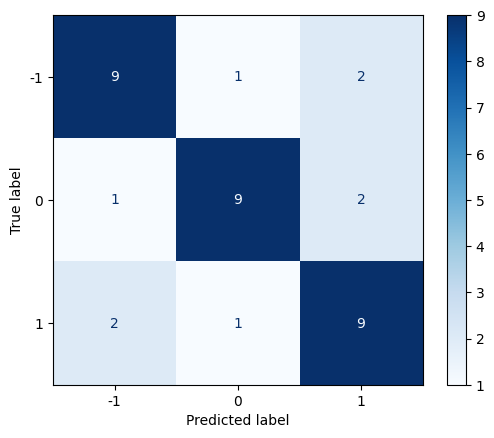

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test - 1, np.argmax(preds[9][test_idx], axis=1) - 1, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [12]:
# Phase2 Test labels accuracy
np.mean(accs)

0.6857638888888888

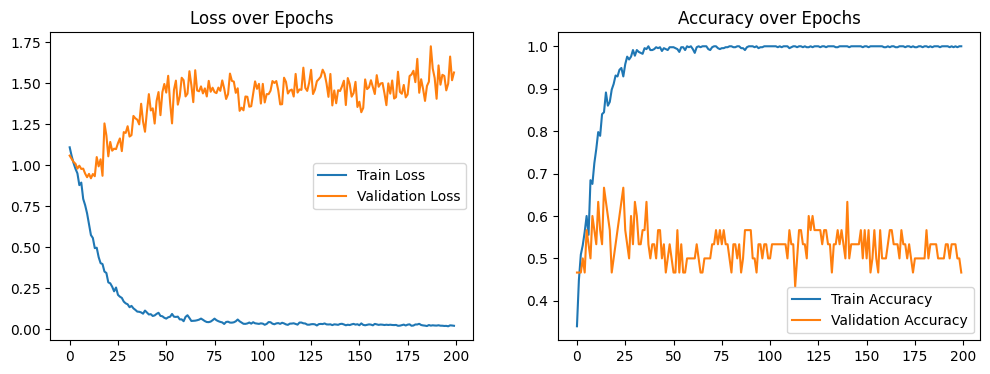

In [6]:
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history["class_loss"], label="Train Loss")
# plt.plot(history.history["val_class_loss"], label="Validation Loss")
# plt.legend()
# plt.title("Loss over Epochs")
# 
# plt.subplot(1, 2, 2)
# plt.plot(history.history["class_accuracy"], label="Train Accuracy")
# plt.plot(history.history["val_class_accuracy"], label="Validation Accuracy")
# plt.legend()
# plt.title("Accuracy over Epochs")
# plt.show()

In [9]:
# from sklearn.model_selection import train_test_split
# from keras_tuner import HyperModel
# from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, Dropout, Dense, concatenate
# from keras.models import Model
# from keras.optimizers import Adam
# from keras.regularizers import l2
# from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
# 
# class MyHyperModel(HyperModel):
#     def __init__(self):
#         self.input_shape_1d = (train.shape[1], train.shape[2])
#         self.input_shape_2d = (train.shape[1], train.shape[2], 1)
#         self.input_shape_bio = (bio.shape[1], bio.shape[2], 4)
# 
#     def build(self, hp):
# 
#         # 1D CNN for temporal data
#         input_1d = Input(shape=self.input_shape_1d)
#         x1 = LSTM(hp.Choice(name="lstm_units", values=[16,32,64,128,256]), activation=hp.Choice("activation1", ["relu", "tanh"]))(input_1d)
#         # x1 = Conv1D(filters=hp.Choice(name="conv1d_filters1", values=[16,32,64,128,256]), kernel_size=3, activation=hp.Choice("activation1", ["relu", "tanh"]))(input_1d)
#         # x1 = MaxPooling1D(pool_size=2)(x1)
#         # x1 = Conv1D(filters=hp.Choice(name="conv1d_filters2", values=[16,32,64,128,256]), kernel_size=3, activation=hp.Choice("activation2", ["relu", "tanh"]))(x1)
#         # x1 = MaxPooling1D(pool_size=2)(x1)
#         x1 = Dropout(hp.Choice(name="dropout1", values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(x1)
#         # x1 = Flatten()(x1)
# 
#         # 2D CNN for spatial data
#         input_2d = Input(shape=self.input_shape_2d)
#         x2 = Conv2D(filters=hp.Choice(name="conv2d_filters1", values=[16,32,64,128,256]), kernel_size=(3, 3), activation=hp.Choice("activation3", ["relu", "tanh"]))(input_2d)
#         x2 = MaxPooling2D(pool_size=(2, 2))(x2)
#         x2 = Conv2D(filters=hp.Choice(name="conv2d_filters2", values=[16,32,64,128,256]), kernel_size=(3, 3), activation=hp.Choice("activation4", ["relu", "tanh"]))(x2)
#         x2 = MaxPooling2D(pool_size=(2, 2))(x2)
#         x2 = Dropout(hp.Choice(name="dropout2", values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(x2)
#         x2 = Flatten()(x2)
# 
#         # LSTM for PPG and RSP data
#         input_bio = Input(shape=self.input_shape_bio)
#         x3 = Conv2D(filters=hp.Choice(name="conv2d_bio_filters_1", values=[16,32,64,128,256]), kernel_size=(5, 5), padding="same", activation=hp.Choice("activation5", ["relu", "tanh"]))(input_bio)
#         x3 = Conv2D(filters=hp.Choice(name="conv2d_bio_filters_2", values=[16,32,64,128,256]), kernel_size=(5, 5), padding="same", activation=hp.Choice("activation6", ["relu", "tanh"]))(x3)
#         x3 = MaxPooling2D(pool_size=(2, 2))(x3)
#         x3 = Dropout(hp.Choice(name="dropout3", values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(x3)
# 
#         x3 = Conv2D(filters=hp.Choice(name="conv2d_bio_filters_3", values=[16,32,64,128,256]), kernel_size=(3, 3), padding="same", activation=hp.Choice("activation7", ["relu", "tanh"]))(x3)
#         x3 = Conv2D(filters=hp.Choice(name="conv2d_bio_filters_4", values=[16,32,64,128,256]), kernel_size=(3, 3), padding="same", activation=hp.Choice("activation8", ["relu", "tanh"]))(x3)
#         x3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x3)
#         x3 = Dropout(hp.Choice(name="dropout4", values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(x3)
#         x3 = Flatten()(x3)
# 
#         combined = concatenate([x1, x2, x3])
# 
#         # Fully connected layers
#         fc = Dense(hp.Choice(name="fc_units", values=[16,32,64,128,256]), activation=hp.Choice("activation9", ["relu", "tanh"]))(combined)
#         fc = Dropout(hp.Choice(name="dropout5", values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(fc)
# 
#         # Output layer
#         class_output = Dense(3, activation="softmax")(fc)
# 
#         model = Model(inputs=[input_1d, input_2d, input_bio], outputs=class_output)
# 
#         optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-7, max_value=1e-3, sampling='LOG'))
#         model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# 
#         return model
# 
# 
# hypermodel = MyHyperModel()
# 
# tuner = RandomSearch(
#     hypermodel,
#     objective="val_accuracy",
#     max_trials=100
# )
# 
# # tuner = Hyperband(hypermodel,
# #                  objective='val_accuracy',
# #                  max_epochs=10,
# #                  factor=3,
# #                  directory='my_dir',
# #                  project_name='intro_to_kt')
# 
# 
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 
# X_train_1d, X_val_1d, X_train_2d, X_val_2d, X_train_bio, X_val_bio, y_train, y_val = train_test_split(
#     train, np.expand_dims(train, axis=-1), bio, target, test_size=0.01, random_state=42, shuffle=True)
# 
# print(X_train_1d.shape, X_train_2d.shape, X_train_bio.shape, y_train.shape)
# print(X_val_1d.shape, X_val_2d.shape, X_val_bio.shape, y_val.shape)
# 
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# 
# tuner.search([X_train_1d, X_train_2d, X_train_bio], y_train, 
#              epochs=50, 
#              batch_size=32,
#              #validation_data=([fmri_test, np.expand_dims(fmri_test, axis=-1), bio_test], y_test),
#              validation_split=0.2,
#              callbacks=[early_stopping])
# 
# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [10]:
# print(f"""
# The hyperparameter search is complete. The optimal hyperparameters are:
# - Conv1D filters 1: {best_hps.get('lstm_units')}
# - Conv2D filters 1: {best_hps.get('conv2d_filters1')}
# - Conv2D filters 2: {best_hps.get('conv2d_filters2')}
# - Conv2D bio filters 1: {best_hps.get('conv2d_bio_filters_1')}
# - Conv2D bio filters 2: {best_hps.get('conv2d_bio_filters_2')}
# - Conv2D bio filters 3: {best_hps.get('conv2d_bio_filters_3')}
# - Conv2D bio filters 4: {best_hps.get('conv2d_bio_filters_4')}
# - Activation 1: {best_hps.get('activation1')}
# - Activation 3: {best_hps.get('activation3')}
# - Activation 4: {best_hps.get('activation4')}
# - Activation 5: {best_hps.get('activation5')}
# - Activation 6: {best_hps.get('activation6')}
# - Activation 7: {best_hps.get('activation7')}
# - Activation 8: {best_hps.get('activation8')}
# - Activation 9: {best_hps.get('activation9')}
# - Dropout 1: {best_hps.get('dropout1')}
# - Dropout 2: {best_hps.get('dropout2')}
# - Dropout 3: {best_hps.get('dropout3')}
# - Dropout 4: {best_hps.get('dropout4')}
# - Dropout 5: {best_hps.get('dropout5')}
# - Fully connected units: {best_hps.get('fc_units')}
# - Learning rate: {best_hps.get('learning_rate')}
# """)